Robel and clipping data analysis for Grazing Management and Drought Resilience (GMDR) project Thunder Basin WY

In [21]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

In [26]:
#Import robel and clipping data
robel= pd.read_csv('data/GMDR_ROBEL_2021.csv', parse_dates= {"RobelDate" : ["Year","Month","Date"]})
clips= pd.read_csv('data/GMDR_ExitClips.csv')

# Robel dataframe

In [7]:
# Make a list of just the columns we want
robelcols = ['RobelDate', 'Block', 'Paddock', 'Plot', 'Direction', 'Location', 'Height Hi', 'Height Lo']
robel = robel[robelcols]

In [8]:
#Create robel location column that works for all years
robel['Robel_loc'] = robel['Block'].map(str) + '-' + robel['Paddock'].map(str) + '-' + robel['Location']

In [9]:
#Height Hi and Height lo are datatype object because of non numeric values '.'
robel[robel['Height Lo'] == '.']

,RobelDate,Block,Paddock,Plot,Direction,Location,Height Hi,Height Lo,Robel_loc
257,2019-07-12,3,3,NaN,NaN,1,.,.,3-3-1


In [10]:
#replace '.' with NaN and change datatpe to float
robel.loc[robel['Height Lo'] == '.', 'Height Lo'] = np.nan
robel.loc[robel['Height Hi'] == '.', 'Height Hi'] = np.nan

robel['Height Lo'] = robel['Height Lo'].astype('float64')
robel['Height Hi'] = robel['Height Hi'].astype('float64')

In [11]:
#create year column
robel['Year']=robel['RobelDate'].dt.year

# Exit clips dataframe

In [27]:
# Select columns of interest to work with
clipscols=['Year', 'Date', 'Block', 'Paddock', 'Plot', 'Location', 'GrazingTrt2019', 'GrazingTrt2020', 'GrazingTrt2021', 'g/m2']
clips= clips[clipscols]

In [28]:
# Create robel location column to match the robel dataframe
clips['Robel_loc'] = clips['Block'].map(str) + '-' + clips['Paddock'].map(str) + '-' + clips['Location']


In [14]:
# Assing arbitrary late date  of 8/1 to records without a date
# NOTE: There are no longer any missing dates to assign to Aug. 1
clips['ClipDate']= clips.apply(lambda row: str(row.Year) + '-' + '8-1' if pd.isna(row.Date) else row.Date, axis=1)

# Make Date1 column a date datatype
clips['ClipDate']= pd.to_datetime(clips['ClipDate'])

In [15]:
robelclip= pd.merge_asof( clips.sort_values('ClipDate'),
                         robel.sort_values('RobelDate'),
                         left_on= 'ClipDate',
                         right_on= 'RobelDate',
                         by=['Block', 'Paddock', 'Robel_loc'],
                         direction= 'nearest',
                         tolerance= datetime.timedelta(days= 22),
                         suffixes=['_clip', ''])

In [16]:
robelclipmean= robelclip.groupby(['Block', 'Paddock', 'Year']).mean()
robelclipmean

Year_clip  Plot_clip        g/m2  Plot  Height Hi  \
Block Paddock Year                                                      
1     1       2019     2019.0        2.0  139.933333   NaN  33.333333   
              2020     2020.0       15.5   23.866667  15.5  12.000000   
              2021     2021.0       15.5   47.966667  15.5  13.666667   
      2       2019     2019.0        2.0  116.400000   NaN  20.666667   
              2020     2020.0        3.5   35.250000   3.5  12.666667   
              2021     2021.0        3.5   78.466667   3.5  14.833333   
      3       2019     2019.0        2.0  173.133333   NaN  21.000000   
              2020     2020.0        9.5   33.850000   9.5   8.166667   
              2021     2021.0        9.5   50.100000   9.5  10.000000   
2     1       2019     2019.0        2.0  105.866667   NaN  22.333333   
              2020     2020.0       27.5   29.383333  27.5   6.333333   
              2021     2021.0       27.5   40.650000  27.5  12.000000   
      2       2019     2019.0        2.0   48.733333   NaN  30.000000   
              2020     2020.0       21.5   27.716667  21.5   7.000000   
              2021     2021.0       21.5   39.933333  21.5   8.833333   
      3       2019     2019.0        2.0   70.466667   NaN  16.333333   
              2020     2020.0       33.5   28.466667  33.5   7.000000   
              2021     2021.0       33.5   43.516667  33.5   8.500000   
3     1       2019     2019.0        2.0  102.666667   NaN  22.333333   
              2020     2020.0       51.5   55.133333  51.5  13.166667   
              2021     2021.0       51.5   52.900000  51.5   9.500000   
      2       2019     2019.0        2.0   59.733333   NaN  17.666667   
              2020     2020.0       45.5   35.766667  45.5   7.166667   
              2021     2021.0       45.5   51.583333  45.5   9.500000   
      3       2019     2019.0        2.0  114.400000   NaN  31.666667   
              2020     2020.0       39.5   55.133333  39.5  11.666667   
              2021     2021.0       39.5   64.650000  39.5  11.166667   

                    Height Lo  
Block Paddock Year             
1     1       2019   5.333333  
              2020   1.833333  
              2021   2.000000  
      2       2019   4.000000  
              2020   1.333333  
              2021   2.833333  
      3       2019   3.333333  
              2020   1.000000  
              2021   1.000000  
2     1       2019   1.666667  
              2020   0.833333  
              2021   0.166667  
      2       2019   2.333333  
              2020   0.833333  
              2021   0.500000  
      3       2019   1.333333  
              2020   0.833333  
              2021   0.666667  
3     1       2019   4.000000  
              2020   1.833333  
              2021   0.500000  
      2       2019   4.333333  
              2020   0.833333  
              2021   0.833333  
      3       2019   5.666667  
              2020   1.666667  
              2021   0.666667

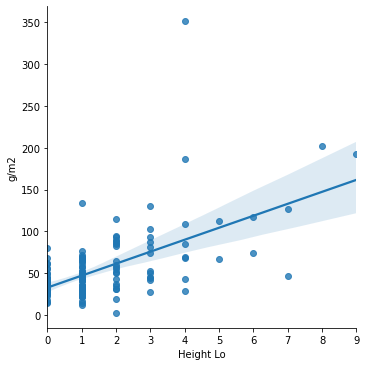

In [17]:
sns.lmplot(x='Height Lo',
y='g/m2',
data=robelclip)

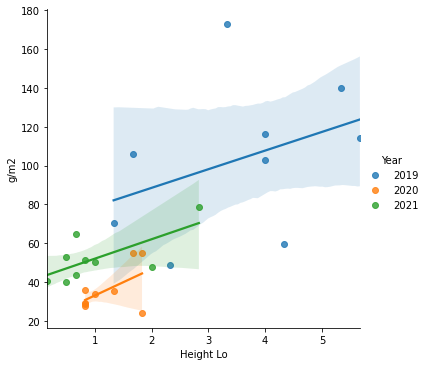

In [20]:
sns.lmplot(x='Height Lo',
y='g/m2',
data=robelclip.groupby(['Block', 'Paddock', 'Year']).mean().reset_index(), hue='Year')

In [47]:
import statsmodels.formula.api as smf

In [48]:
mod_bm = smf.ols("Q('g/m2') ~ Q('Height Lo') + Q('Height Hi')", data=robelclip.groupby(['Block', 'Paddock', 'Year']).mean()).fit()
mod_bm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('g/m2')   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     17.60
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           1.97e-05
Time:                        12:38:27   Log-Likelihood:                -123.65
No. Observations:                  27   AIC:                             253.3
Df Residuals:                      24   BIC:                             257.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         15.1951     10.993      1.382      0.180      -7.494      37.884
Q('Height Lo')     9.1315      5.842      1.563      0.131      -2.925      21.188
Q('Height Hi')     2.1055      1.166      1.806      0.083      -0.300       4.511
==============================================================================
Omnibus:                       15.530   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.764
Skew:                           1.130   Prob(JB):                     6.91e-06
Kurtosis:                       7.002   Cond. No.                         39.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""